# Jonathan's Optical Character Recognition Program
Welcome!

### Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, io
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import copy
from tqdm import tqdm
from PIL import Image as im
from copy import deepcopy

### Setup and Settings
Mounting Drive and configuring the program

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In this cell, there are 5 settings:
 - `model` is the path of the neural network that will be used
 - `classes` is the path of a stored list of class names
 - `path` is the path of the image to be read; two example images are provided on the github
 - `device` which will configure itself based on hardware acceleration
 - `invert` which will invert the colors of the image
  - Images must be light text on dark background to process
  - Enable `invert` if text is dark on light, as is normal for papers

If the image is detected successfully, it will display on this cell's output.

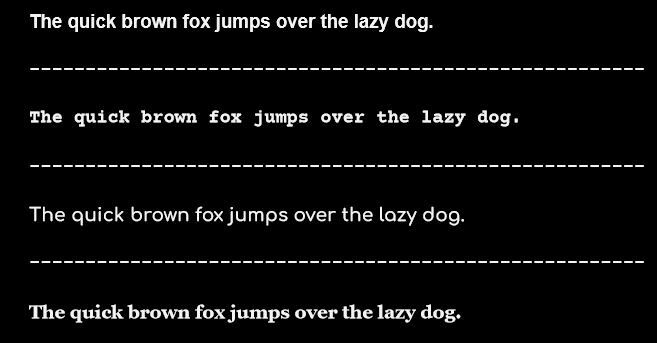

In [ ]:
model = '/content/drive/MyDrive/Datasets/EMNIST/saved models/jnet-expanded-1.dat'
classes = '/content/drive/MyDrive/Datasets/EMNIST/data/class_names.dmp'
path = '/content/drive/MyDrive/test.png'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
invert = False
raw = im.open(path)
raw

## Preprocessing
This section imports the image and prepares it to be read by the neural network.

It has 4 subsections:
 1. Setup: Makes image grayscale, inverts if applicable, and then normalizes
 2. Splitting: Tries to find and separate the image where it can find lines of text
 3. Sampling: Crops the lines at every possible area to ensure every character is found
 4. Interpreting: Filters through the 'loaf' of image samples to find the best pictures of individual characters

Note: Interpreting, typically having to filter through thousands of images, may take some time.

### Image Setup

Image setup; imports the image, grayscales it, and inverts if necessary

In [ ]:
image = im.open(path)
image = image.convert('L')
image = image.convert('RGB')
image = np.array(image.getdata()).reshape(image.size[1], image.size[0], 3).astype(float)/255
if invert: image = 1 - image
im.fromarray((image*255).astype(np.uint8)).show()

This cell defines transformations to normalize and move to a tensor format

In [ ]:
Tensor = transforms.Compose([
    transforms.ToTensor()
])
image = Tensor(image)
mean, std = image.mean([1,2]), image.std([1,2])
Normalize = transforms.Compose([
    transforms.Normalize(mean,std)
])

Here, images are normalized, returned to array form, and given a threshold to keep bright pixels

In [ ]:
image = Normalize(image)
image = image.numpy().transpose(1,2,0)
image[image < 0.75], image[image > 1] = 0,1

In [ ]:
im.fromarray((image*255).astype(np.uint8)).show()

### Line Splitter

In this cell, the image is averaged at every line of pixels to see if it is potentially a line of text

It outputs a list of booleans based on where it finds them, stored in `linemap`

In [ ]:
linemap = []
for i in image:
  linemap.append(np.mean(i))
linemap = [x for x in np.array(linemap) > 0.0025]

This cell uses `linemap` to extract an image for every continuous set of true values, stored in `lines`

In [ ]:
lines, j = [], 0
for i,b in enumerate(linemap):
  if b:
    if len(lines) > 0 and not linemap[i-1]:
      j += 1
    if j + 1 == len(lines):
      lines[j] = np.append(lines[j], np.expand_dims(image[i],0), 0)
    else:
      lines.append(np.expand_dims(image[i],0))

### Image Sampling

This cell:
 1. Scales lines to have a height of 24 pixels
 2. Crops them to remove any hanging areas
 3. Pads them to allow more potential areas in sampling

The reulting images are then stored in `mlines`

In [ ]:
mlines = []
for i in range(len(lines)):
  h = int(lines[i].shape[1] * 24/np.max((lines[i].shape[0],12)))
  mlines.append(cv2.resize(deepcopy(lines[i]),(h,24)))
  mlines[i] = im.fromarray((mlines[i]*255).astype(np.uint8))
  mlines[i] = np.asarray(mlines[i].crop(mlines[i].getbbox())) / 255.
  mlines[i] = cv2.copyMakeBorder(mlines[i],8,8,10,10,cv2.BORDER_CONSTANT)

Using the outputs from the previous cell, this loops through every pixel in each line and returns an image for its local area

This is then stored in `loaf`, named for being a large, 5-dimensional set of data

In [ ]:
loaf = []
for i in range(len(mlines)):
  loaf.append([])
  for j in range(mlines[i].shape[1]-28):
    loaf[i].append(deepcopy(mlines[i][:,j:j+28]))

### Interpretation

This function- dubbed "greenerizing"- is the most integral part to finding which images from the loaf are viable candidates to be used.

It works by:
 1. Tinting every white pixel in the center of an image green
 2. Then, in a loop, tints every pixel neighboring a green pixel green
 3. After the loop, it throws away all remaining non-green pixels and restores all others to white

In doing this, this function will isolate whichever figure is in the middle of an image.

In [ ]:
def greenerize(input):
  otpt = deepcopy(input)
  for t in (0,1,2):
    for r in range(13):
      for p in np.arange(1,len(otpt)-1):
        # Green Stripe
        if r==0 and p < len(otpt)-2:
          for s in range(2):
            otpt[p+1,13+s] = (0,otpt[p+1,13+s,1],0)
        # Greenify nearby pixels per loop
        if any(((otpt[p-1,13-r,0] < otpt[p-1,13-r,1] and otpt[p-1,13-r,1] > 0.5), (otpt[p,13-r,0] < otpt[p,13-r,1] and otpt[p,13-r,1] > 0.5), (otpt[p+1,13-r,0] < otpt[p+1,13-r,1] and otpt[p+1,13-r,1] > 0.5))): otpt[p,12-r] = (0,otpt[p,12-r,1],0)
        if any(((otpt[p-1,14+r,0] < otpt[p-1,14+r,1] and otpt[p-1,14+r,1] > 0.5), (otpt[p,14+r,0] < otpt[p,14+r,1] and otpt[p,14+r,1] > 0.5), (otpt[p+1,14+r,0] < otpt[p+1,14+r,1] and otpt[p+1,14+r,1] > 0.5))): otpt[p,15+r] = (0,otpt[p,15+r,1],0)
    for r in range(39):
      for p in range(28):
        if otpt[r-1,p,0] < otpt[r-1,p,1] and otpt[r-1,p,1] > 0.5: otpt[r,p] = (0,otpt[r,p,1],0)
        if otpt[39-r,p,0] < otpt[39-r,p,1] and otpt[39-r,p,1] > 0.5: otpt[38-r,p] = (0,otpt[38-r,p,1],0)
  for r in range(28):
    for p in range(40):
      # Remove non-green pixels
      if otpt[p,r,1] > otpt[p,r,0]: otpt[p,r] = (otpt[p,r,1],otpt[p,r,1],otpt[p,r,1])
      else: otpt[p,r] = (0,0,0)
  return otpt

This cell has all the logic used to determine which characters are valid to send to the neural network.

For each image in each line of `loaf`, it:
 1. Tests to see if the center of is empty, in which interprets as a space, and stores the index in `spaces`
 2. Greenerizes them (see previous cell)
 3. Tests to see that the left and right margins of the image are equal
 4. Tests to see if the image still contains multiple characters
  - If it is, it sends a note forward to see if other future images are also attached
  - Future attached images are then edited to be valid entries
 5. Finally, any valid images at this point are cropped 28 pixels height and appended to `stack`

After this cell runs, `stack` should include only centered characters and `spaces` should include the index of each space in a line

In [ ]:
stack, spaces = [], []
for i in range(len(loaf)):
  stack.append([]),spaces.append([])
  note = -1
  for j in tqdm(range(len(loaf[i]))):
    elem = deepcopy(loaf[i][j])
    elem[elem<=0.1] = 0
    # Space Detection
    if all(np.mean(np.mean(elem,0),1)[12:17] == 0) and len(stack[i]) >= 1:
      if len(spaces[i]) == 0 or spaces[i][-1] != len(stack[i]):
        spaces[i].append(len(stack[i]))
    # Greenerizing
    elem = greenerize(elem)
    # Filtering
    elem = im.fromarray((elem*255).astype(np.uint8))
    box,typ = elem.getbbox(),''
    if box == None: continue
    if box[0] == 7 and box[2] == 28 and j+7 < len(loaf[i]) and  all(np.mean(np.mean(greenerize(loaf[i][j+7]),0),1) > 0): typ,note = 'break',j+14
    if box[0] == 0 and box[2] == 21 and j-7 >= 0 and all(np.mean(np.mean(greenerize(loaf[i][j-7]),0),1) > 0): typ = 'break'
    if box[0] == 0 and box[2] == 28 and note == j: typ = 'break'
    if typ == '' and (box[0]+box[2]-28 == 0 if (box[0]+box[2])%2 == 0 else box[0]+box[2]-28 == 1): typ = 'norm'
    if typ == 'break' or typ == 'norm':
      # Crop to center
      dh = box[3] - box[1]
      h1,h2 = (int(box[1]-(28-dh)/2) if dh%2 == 0 else int(box[1]-(27-dh)/2)),(int(box[3]+(28-dh)/2) if dh%2 == 0 else int(box[3]+(29-dh)/2))
      elem = np.asarray(elem.crop((0,h1,28,h2)))/255.
      # Split Touching Characters
      if typ == 'break': elem[:,21:],elem[:,:7] = 0,0
      if all(np.mean(np.mean(elem,0),1)[12:17] > 0.01):
        if np.mean(np.mean(elem,0),1)[0] == 0 and np.mean(np.mean(elem,0),1)[27] == 0:
          # Append finalized character, few will make it this far!
          stack[i].append(elem)

100%|██████████| 538/538 [00:10<00:00, 49.10it/s]


## Model
This section prepares the neural network and reads the previously generated character images.

It also has 4 subsections:
 1. Preparation: Creating the model framework and loading it in from the path
 2. Modeling: Applying the model to the character images
 3. Processing: Taking the model's outputs and turning them into readable text
 4. Output: Presenting the final results

Ensure you have a valid, trained model file for this to run properly.

### Preparation

This model uses Alexnet as a template.

In [ ]:
alexnet = models.alexnet(weights = None)

In order to support 28x28 images, the network has to be edited:
 - The layers around convolution steps 3 and 4 are deleted
 - The remaining convolutional layers must use smaller kernels with padding
 - The final classification layer must output to 67 classes instead of 1000

In [ ]:
jnet = copy.deepcopy(alexnet)
del(jnet.features[5:10])
jnet.features[0] = nn.Conv2d(3, 32, kernel_size=(5,5), stride=(1,1), padding='same')
jnet.features[3] = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding='same')
jnet.features[5] = nn.Conv2d(64, 256, kernel_size=(3,3), stride=(1,1), padding='same')
jnet.classifier[6] = nn.Linear(4096, 67)
jnet = jnet.to(device)

Loading the trained model and class names

In [ ]:
jnet.load_state_dict(torch.load(model,map_location=device))
class_names = torch.load(classes)

### Modeling

In order to work with the neural network, the data must first be moved to a Tensor on the valid device.

All the characters in each line are stacked into a single tensor.

In [ ]:
data = []
for i in range(len(stack)):
  data.append([])
  for j in range(len(stack[i])):
    data[i].append(Tensor(stack[i][j]))
  data[i] = torch.stack(data[i],0).type(torch.float32) if not torch.cuda.is_available() else torch.stack(data[i],0).type(torch.cuda.FloatTensor)

Finally, the tensors are sent through the model; the outputs are sent to `predictions` as an array of integers referring to classes.

In [ ]:
jnet.eval()
predictions = []
for i in range(len(data)):
  output = jnet(data[i].to(device))
  output = torch.max(output, 1)[1]
  predictions.append(output.cpu().detach().numpy())

### Processing

This cell substitutes the integers from the predictions to the corresponding class in `class_names`.

In [ ]:
for i in range(len(predictions)):
  predictions[i] = [class_names[x] for x in predictions[i]]

Here, spaces are appended to the predictions at every index in `spaces`.

In [ ]:
for i in range(len(spaces)):
  for j,k in enumerate(spaces[i]):
    predictions[i].insert(j+k,' ')

### Output

Run this to get the model's interpretation of the image's text!

Input:


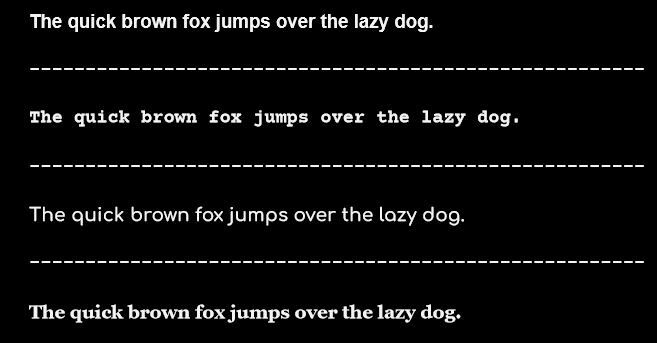


Outputs:
-------------------------
Tne quick Drovnn qoxjumps overine iazy dog
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
zuo g4:cx bio*n Eoz jnups ovo* tno 2az8 aog
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
The qui:k brown fo*jumps oer :ho lom dog
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
zue qwdkbba mxjvwuBs ov:weiwy adB


In [ ]:
print('Input:')
display(raw)
print('\nOutputs:\n'+'-'*25)
for i in range(len(predictions)):
  print(''.join(predictions[i]))